In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import strip_punctuation
print((gensim.__version__)) 

4.1.2


### Global importances of words

In [2]:
shap_df = pd.read_csv("C:/Users/berl03/Desktop/LIME/4 SHAP  výpočet/shap_imp.csv")

In [3]:
lime_df = pd.read_csv("C:/Users/berl03/Desktop/LIME/3 LIME výpočet/lime_df_fin_v2.csv")[["word","global_lime_importance","global_avg_importance"]]
df_smer = pd.read_csv("C:/Users/berl03/Desktop/LIME/2 SMER výpočet/SMER_new.csv").drop(columns=["Unnamed: 0"])[["word","score"]]

In [4]:
df_gsi = pd.read_csv("C:/Users/berl03/Desktop/LIME/5 global_surrogate/global_word_importance_bow_surrogate.csv")

In [5]:
# udelat společnou sadu slov
df_all = lime_df.merge(df_smer,on="word",how="inner").merge(shap_df,on="word",how="inner").merge(df_gsi,on="word",how="inner")

In [6]:
df_all

word  global_lime_importance  global_avg_importance     score  \
0                icu               10.904456               0.528476  0.984267   
1         antibiotic                2.502440               0.481708  0.137217   
2               line                3.095883               0.479225  0.084139   
3          infection               11.394408               0.515208  0.712409   
4            vaccine               11.848866               0.531802  0.901991   
...              ...                     ...                    ...       ...   
1080        original                0.744733               0.554627  0.590161   
1081     detrimental                0.693779               0.481329  0.215938   
1082        platform                0.714705               0.510803  0.380243   
1083      researcher                0.718088               0.515650  0.573585   
1084  stratification                0.712190               0.507214  0.699364   

      Unnamed: 0_x      shap  Unnamed: 0_y    importance  importance_norm  
0            16914  0.063926            42  1.941655e-03     8.178226e-03  
1             5092  0.002861           551  1.823890e-04     7.682200e-04  
2            19563  0.005297          1178  3.270729e-05     1.377627e-04  
3            17721  0.007863             9  1.247435e-02     5.254179e-02  
4            34570  0.009384           155  7.118933e-04     2.998485e-03  
...            ...       ...           ...           ...              ...  
1080         23913  0.012862          2389  5.372715e-07     2.262980e-06  
1081         11001  0.001083          1180  3.265253e-05     1.375320e-04  
1082         25505  0.007708          1104  4.172019e-05     1.757249e-04  
1083         28350  0.006879          1356  1.732484e-05     7.297199e-05  
1084         31455  0.003950          3201  4.513075e-09     1.900889e-08  

[1085 rows x 9 columns]

### Logistic regression & documents & embedding model

In [7]:
df_abstract = pd.read_csv("C:/Users/berl03/Desktop/LIME/1 příprava dat/y_test.csv")[["abstract_cleaned"]].drop_duplicates().rename({"abstract_cleaned":"abstract_text"},axis=1)
model_w2v=gensim.models.Word2Vec.load("C:/Users/berl03/Desktop/LIME/1 příprava dat/w2v_published_only_english_between_2019 and 2020.model")
loaded_model = lreg_w2v_avg = pickle.load(open("C:/Users/berl03/Desktop/LIME/1 příprava dat/lreg_w2v_avg_2020.sav", 'rb'))

## Calculate global word metrics

## Evaluate Global Scores - AOPCglobal

In [8]:
# --- Funkce pro predikci pravděpodobností (beze změny) ---------------------
def predict_probabilities_from_text(texts: list[str]) -> np.ndarray:
    vectors = []
    for text in texts:
        words = [w for w in text.split() if w in model_w2v.wv]
        if words:
            vectors.append(np.mean([model_w2v.wv[w] for w in words], axis=0))
        else:
            vectors.append(np.zeros(model_w2v.vector_size))
    return loaded_model.predict_proba(vectors)

In [9]:
def remove_words(text, words_to_remove):
    # původní remove_words zůstává beze změny
    return ' '.join([w for w in text.split() if w not in words_to_remove])

def compute_AOPCglobal(df, df_abstracts, metric_colname, max_K=10):
    # 1) seřazení slov
    ranked_words_global = (
        df.groupby("word")[metric_colname]
          .mean()
          .sort_values(ascending=False)
          .index
          .tolist()
    )

    # 2) unikátní texty a jejich tokenové sady
    texts = df_abstracts["abstract_text"].unique()
    wordsets = [set(t.split()) for t in texts]

    # 3) původní predikce (jednou pro všechna abstrakta)
    orig_preds = predict_probabilities_from_text(list(texts))
    orig_probs = [p[1] for p in orig_preds]

    avg_drops = []

    # 4) pro každé K děláme jeden batch predict
    for K in tqdm(range(0, max_K + 1)):
        altered_texts = []
        # připravíme všechny upravené texty najednou
        for ws, text in zip(wordsets, texts):
            top_k = [w for w in ranked_words_global if w in ws][:K]
            altered_texts.append(remove_words(text, top_k))

        # batchová predikce upravených textů
        altered_preds = predict_probabilities_from_text(altered_texts)
        altered_probs = [p[1] for p in altered_preds]

        # spočítáme drop pro každý dokument (0 pokud se nezměnil)
        drops = [
            (orig - alt) if orig_text != alt_text else 0
            for orig, alt, orig_text, alt_text
            in zip(orig_probs, altered_probs, texts, altered_texts)
        ]

        avg_drops.append(np.mean(drops))

    return avg_drops


In [10]:
AOPC_SMER = compute_AOPCglobal(df_all, df_abstract, 'score', max_K=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:27<00:00,  2.51s/it]


In [11]:
AOPC_LIME = compute_AOPCglobal(df_all,df_abstract, "global_lime_importance", max_K=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:27<00:00,  2.51s/it]


In [12]:
AOPC_Avg = compute_AOPCglobal(df_all, df_abstract, "global_avg_importance", max_K=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:27<00:00,  2.53s/it]


In [13]:
random_ranked_words = df_all["word"].unique()
np.random.seed(35)
np.random.shuffle(random_ranked_words)
random_df = df_all.copy()
random_df["random_importance"] = random_df["word"].map({word: rank for rank, word in enumerate(random_ranked_words)})

AOPC_Random = compute_AOPCglobal(random_df, df_abstract, "random_importance", max_K=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:29<00:00,  2.64s/it]


In [14]:
AOPC_shap = compute_AOPCglobal(df_all, df_abstract, "shap", max_K=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:28<00:00,  2.63s/it]


In [15]:
AOPC_gsi = compute_AOPCglobal(df_all, df_abstract, "importance_norm", max_K=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:27<00:00,  2.53s/it]


## Calculate Area Under AOPCglobal

In [16]:
df_results = pd.DataFrame({
"AOPC_RANDOM": AOPC_Random,
"AOPC_LIME": AOPC_LIME,
"AOPC_AVG": AOPC_Avg ,
"AOPC_SMER": AOPC_SMER,
"AOPC_SHAP":AOPC_shap,
"AOPC_GSI":AOPC_gsi,
})

In [17]:
def area_between_curves(df, curve1, curve2):
    return 0.5 * sum([(df[curve1][i] + df[curve1][i-1] - df[curve2][i] - df[curve2][i-1]) for i in range(1, len(df[curve1]))])

results = pd.DataFrame({
    "area_under_APOC_global_lime": area_between_curves(df_results, "AOPC_LIME", "AOPC_RANDOM"),
    "area_under_APOC_smer": area_between_curves(df_results, "AOPC_SMER", "AOPC_RANDOM"),
    "area_under_APOC_avg_lime": area_between_curves(df_results, "AOPC_AVG", "AOPC_RANDOM"),
    "area_under_APOC_shap": area_between_curves(df_results, "AOPC_SHAP", "AOPC_RANDOM"),
    "area_under_APOC_gsi": area_between_curves(df_results,"AOPC_GSI","AOPC_RANDOM"),
}, index=[0])

results_transposed = results.T
results_transposed.columns = ['value']
results_transposed.sort_values("value",ascending=False).round(10)

value
area_under_APOC_smer         0.494753
area_under_APOC_avg_lime     0.477318
area_under_APOC_shap         0.328407
area_under_APOC_gsi          0.268522
area_under_APOC_global_lime  0.260698

## Final

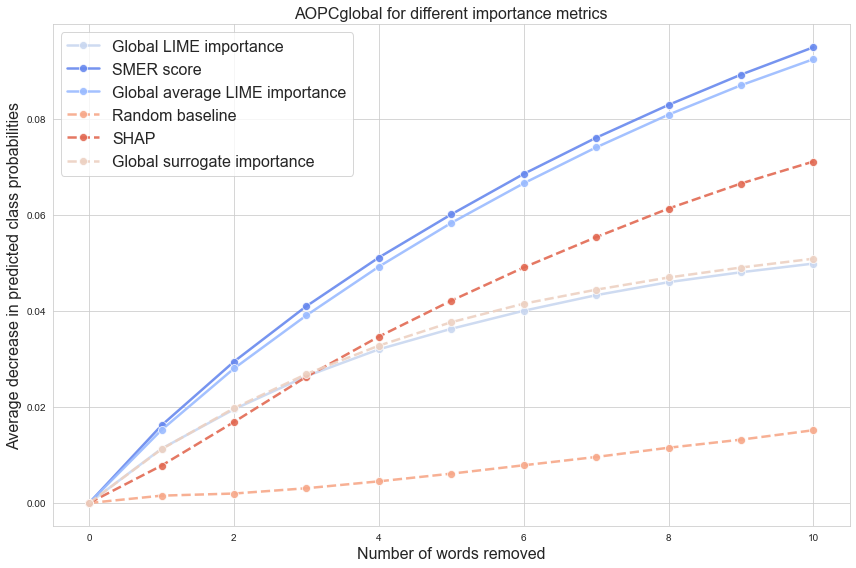

In [18]:
colors = sns.color_palette("coolwarm")

plt.figure(figsize=(12, 8))
def plot_AOPCglobal(ax, values, label, linestyle, marker, color):
    sns.lineplot(x=range(0, 11), y=values, ax=ax, label=label, linestyle=linestyle, marker=marker, color=color, linewidth=2.5, markersize=8, alpha=0.9)

sns.set_style("whitegrid")
ax = plt.gca()

# Plot AOPCglobal values for each metric and the random baseline using the colors from the 'colors' list
plot_AOPCglobal(ax, df_results.AOPC_LIME, 'Global LIME importance', '-', 'o', colors[2])
plot_AOPCglobal(ax, df_results.AOPC_SMER, 'SMER score', '-', 'o', colors[0])
plot_AOPCglobal(ax, df_results.AOPC_AVG, 'Global average LIME importance', '-', 'o', colors[1])
plot_AOPCglobal(ax, df_results.AOPC_RANDOM, 'Random baseline', '--', 'o', colors[4])
plot_AOPCglobal(ax, df_results.AOPC_SHAP, 'SHAP', '--', 'o', colors[5])
plot_AOPCglobal(ax, df_results.AOPC_GSI, 'Global surrogate importance', '--', 'o', colors[3])

# Setting labels, title, and legend
ax.set_xlabel('Number of words removed', fontsize=16)
ax.set_ylabel('Average decrease in predicted class probabilities', fontsize=16)
ax.set_title('AOPCglobal for different importance metrics', fontsize=16)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=16)

plt.tight_layout()
plt.show()